#### Kaggle API installation:
 - `pip install kaggle`
 - Go to https://github.com/Kaggle/kaggle-api and read the **API credentials part**
 - Register or login in https://kaggle.com
 - Go to https://www.kaggle.com/c/test-recsys and push **Join Competition**
 
#### Data download
 - Download data `kaggle competitions download -c test-recsys`
 - Unpack data `unzip test-recsys.zip -d data`

In [306]:
import os
import json
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def count_plot(df, x, title='', figsize=(18, 6), top=None, **kwargs):
    plt.figure(figsize=(18, 6))

    val_cnt = df[x].value_counts()
    val_cnt = val_cnt.iloc[:top] if top else val_cnt

    sns.countplot(data=df, x=x, order=val_cnt.index, **kwargs)
    plt.xticks(rotation=90, fontsize=12)
    if title:
        plt.title(title, fontsize=16)
    else:
        plt.title(f'{x.capitalize()} count', fontsize=16)
    plt.plot()

### Data paths

In [259]:
PATH_TO_PRODUCTS = 'data/sbermarket_tab_2_1/'
PATH_TO_ORDERS = 'data/kaggle_tab_1345/tab_1_orders.csv'
PATH_TO_CATS = 'data/kaggle_tab_1345/tab_3_categories.csv'
PATH_TO_PROD_PROP = 'data/kaggle_tab_1345/tab_5_product_properties.csv'
PATH_TO_USERS = 'data/kaggle_tab_1345/tab_4_user_profiles.csv'
PATH_TO_CITIES = 'data/tab_6_city.csv'
PATH_TO_SMPL_SUBM = 'data/sample_submission.csv'

PRODUCT_TABS = os.listdir(PATH_TO_PRODUCTS)

PATH_TO_PREPROC_DATA = 'preprocessed_data'
os.makedirs(PATH_TO_PREPROC_DATA, exist_ok=True)

In [291]:
EMPTY_CAT = '#empty#'

## Orders

In [292]:
orders_df = pd.read_csv(PATH_TO_ORDERS)
retailer_popularity = dict((orders_df.retailer.value_counts()/len(orders_df)))

In [294]:
retailer_threshold = 1e-1
most_popular_retailers = {k: v for k, v in retailer_popularity.items() if v > retailer_threshold}
orders_df.retailer = orders_df.retailer.apply(lambda x: x if x in most_popular_retailers else EMPTY_CAT)

In [295]:
most_popular_platforms = ['app', 'web']
orders_df.platform = orders_df.platform.apply(lambda x: x if x in most_popular_platforms else EMPTY_CAT)

In [442]:
orders_df.sample(5)

,user_id,order_id,order_created_time,retailer,store_id,platform
2149133,2530829,14137315,2020-07-29 01:56:51,METRO,152,app
1044320,1426907,9652855,2020-05-06 21:44:34,METRO,8,app
892023,1285989,17005469,2020-09-19 18:05:53,METRO,65,app
359883,671860,6530592,2020-02-24 10:27:41,METRO,65,app
1422978,1742764,9509353,2020-05-04 11:23:46,METRO,65,web


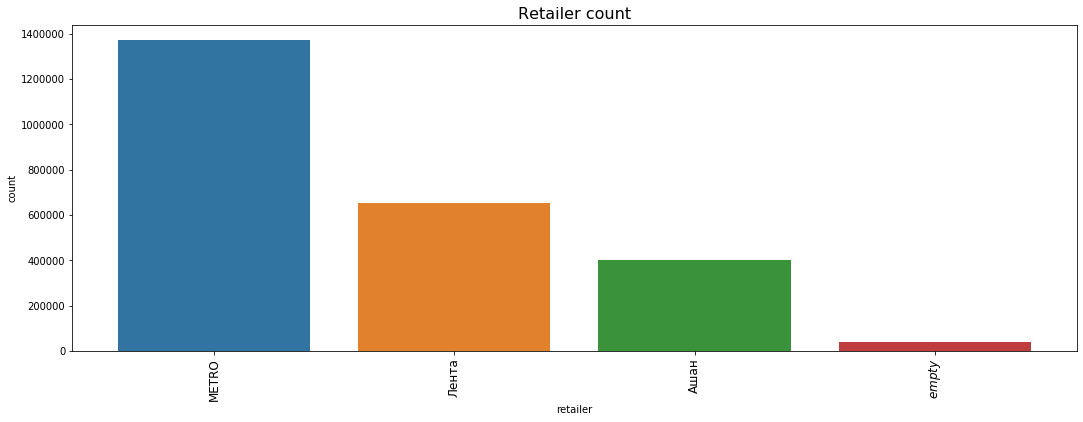

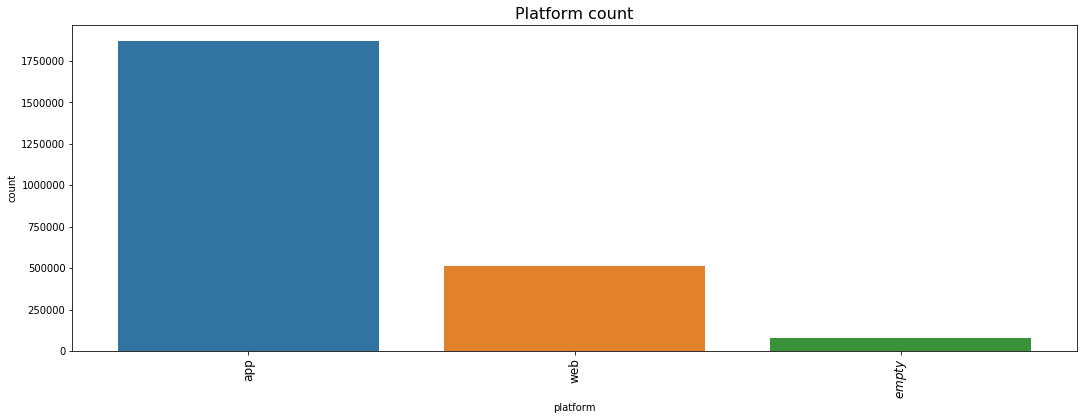

In [271]:
count_plot(orders_df, 'retailer', top=10)
count_plot(orders_df, 'platform')

## Categories

`category` is a higher category level over master_category.

TODO: 
 - *Reorganize the categories data to a tree*, e.g., using the `json` strucure

In [443]:
cat_df = pd.read_csv(PATH_TO_CATS, index_col='id')
cat_df.parent_id[956] = 547 # The Огнетушители category has wrong parent_id

/home/a_belov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [444]:
def create_path_list(df, x):
    path = [x]
    while True:
        x = df.loc[x].parent_id
        
        if x == 0:
            break
        path.append(x)

    return path[::-1]


def create_tree_prod_cats(df):
    cat_id_tree = dict()
    cat_name_tree = dict()

    for i, row in df.iterrows():
        path = create_path_list(df, row.name)

        level_id = cat_id_tree
        level_name = cat_name_tree

        while True:
            v = int(path.pop(0))

            if path:
                if not isinstance(level_id.get(v), dict):
                    level_id[v] = dict()
                    level_name[df.name[v]] = dict()

                level_id = level_id[v]
                level_name = level_name[df.name[v]]
            else:
                level_id[v] = None
                level_name[df.name[v]] = None

                break
                
    return cat_id_tree, cat_name_tree

In [445]:
cat_id_tree, cat_name_tree = create_tree_prod_cats(cat_df)

with open('data/cat_id_tree.json', 'w') as f:
    json.dump(cat_id_tree, f)
    
with open('data/cat_name_tree.json', 'w') as f:
    json.dump(cat_name_tree, f, ensure_ascii=False)

## User profiles

In [446]:
def date_parser_users(d):
    try:
        d = datetime.strptime(d, '%Y-%m-%d')
    except ValueError:
        try:
            d = datetime.strptime(d, '%d.%m.%Y')
        except:
            d = datetime.strptime(d, '%d.%m')

    return d

In [461]:
users_df = pd.read_csv(PATH_TO_USERS)
users_df.gender = users_df.gender.fillna(EMPTY_CAT)

,user_id,gender,bdate
0,2224890,#empty#,NaN
1,1683001,male,1987-10-11
2,2102480,#empty#,NaN
3,2224895,#empty#,NaN
4,930197,#empty#,NaN
...,...,...,...
438862,3424212,female,1997-09-15
438863,3424222,male,1978-09-18
438864,3424225,female,1981-11-02
438865,3424228,female,1993-10-04


In [448]:
current_year = 2020
min_age, max_age = 13, 65

users_df['age'] = users_df.bdate.apply(lambda x: 
                                    0 if pd.isna(x) else 
                                    current_year - date_parser_users(x).year
                                   )

users_df.age[(users_df.age < min_age) | (users_df.age > max_age)] = 0

/home/a_belov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


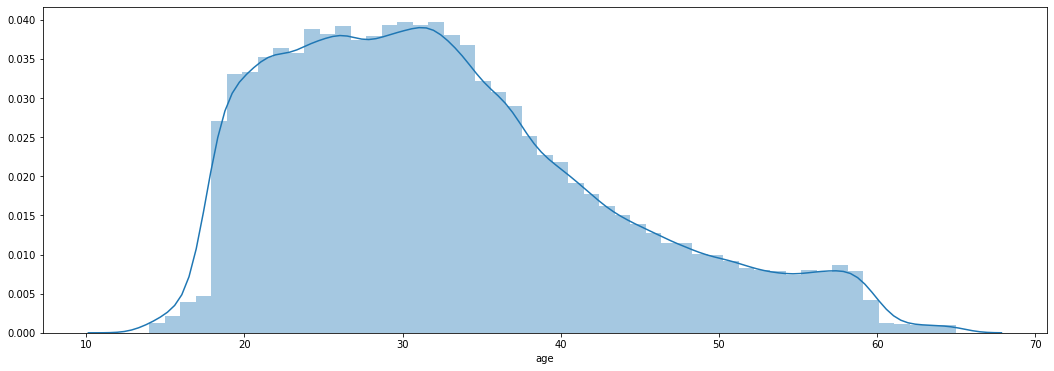

In [449]:
plt.figure(figsize=(18, 6))
sns.distplot(users_df[users_df.age != 0].age, bins=max_age-min_age+1)

In [450]:
users_df.head()

,user_id,gender,bdate,age
0,2224890,#empty#,NaN,0
1,1683001,male,1987-10-11,33
2,2102480,#empty#,NaN,0
3,2224895,#empty#,NaN,0
4,930197,#empty#,NaN,0


## Product properties

Each product has several properties.

Each properties has `property_nam`e and `property_value`.

Examples of property_name - *Вес (Weight), Вид (Taste), ...* (around 6000 possible variants).

Examples of property_value - *100 г , Черника (Blueberry) etc*.

TODO:
- We neead an idea what to do with this data and how proccess it 

In [451]:
prod_prop_df = pd.read_csv(PATH_TO_PROD_PROP)

In [452]:
prod_prop_df.head()

,product_id,property_name,property_value
0,1,Вес,100 г
1,2,Вид,Молочный напиток
2,2,Вес,100 г
3,2,Вкус,Черника
4,2,Сырье,Натуральное молоко


In [453]:
prod_prop_df.product_id.unique().shape

(686344,)

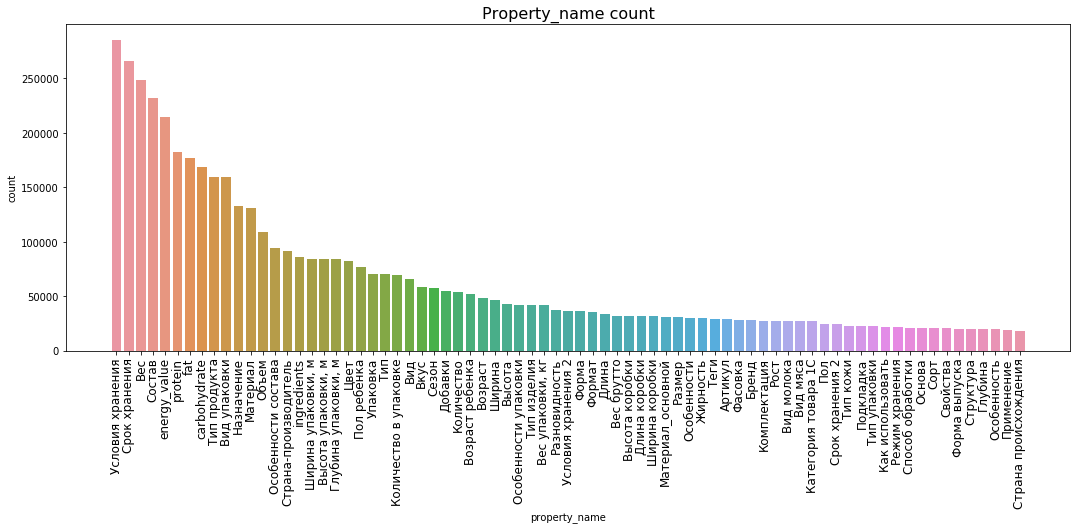

In [454]:
count_plot(prod_prop_df, 'property_name', top=75)

## Cities

In [195]:
cities_df = pd.read_csv(PATH_TO_CITIES)

In [196]:
cities_df.head()

,store_id,city_name
0,14,Москва
1,21,Москва
2,1,Москва
3,4,Москва
4,7,Москва


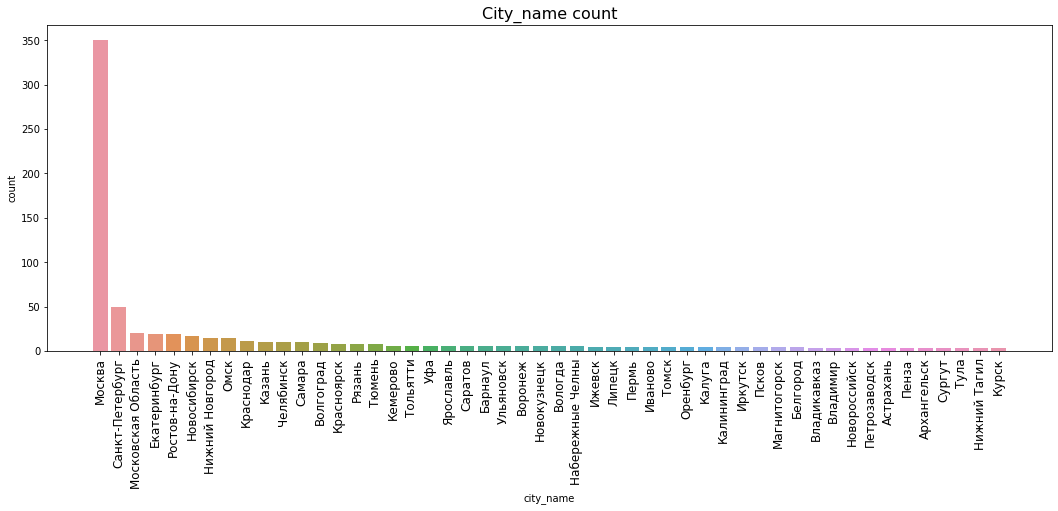

In [106]:
count_plot(cities_df, 'city_name', top=50)

## Products

`master_category` is the lowest level category. Each product belongs to one `master_category`.

`line_item_id` is the product's position in the order.

`price` is the actual amount of money the user paid for the product. The `discount` is calculated as difference between the `price` which the user payed and the regular product price.

In [455]:
prod_df = pd.read_csv(os.path.join(PATH_TO_PRODUCTS, PRODUCT_TABS[0]))

In [456]:
prod_df.head()

,user_id,order_id,line_item_id,price,quantity,discount,product_name,product_id,brand_name,master_category_id,parent_category_id
0,51,6126665,34133962,337.000000,2,0.0,Гель Tiret Turbo для устранения сложных засоро...,8097,Tiret,259.0,252
1,51,6126665,34133995,547.000000,1,0.0,Гель Tiret Turbo для прочистки труб 1 л,8104,Tiret,259.0,252
2,51,6126665,34134027,475.929993,1,0.0,Гель Tiret Professional для устранения и профи...,8062,Tiret,259.0,252
3,51,6126665,34428669,379.000000,4,0.0,Лак Syoss Salonplex для волос 400 мл,3594274,Syoss,177.0,175
4,51,6126665,35127463,529.900024,1,0.0,Авокадо Tropical 500 г,5481646,Без бренда,85.0,84


In [457]:
order_id = set(orders_df.order_id.values)
order_id_prod = set(prod_df.order_id.values)

order_ids = order_id.intersection(order_id_prod)

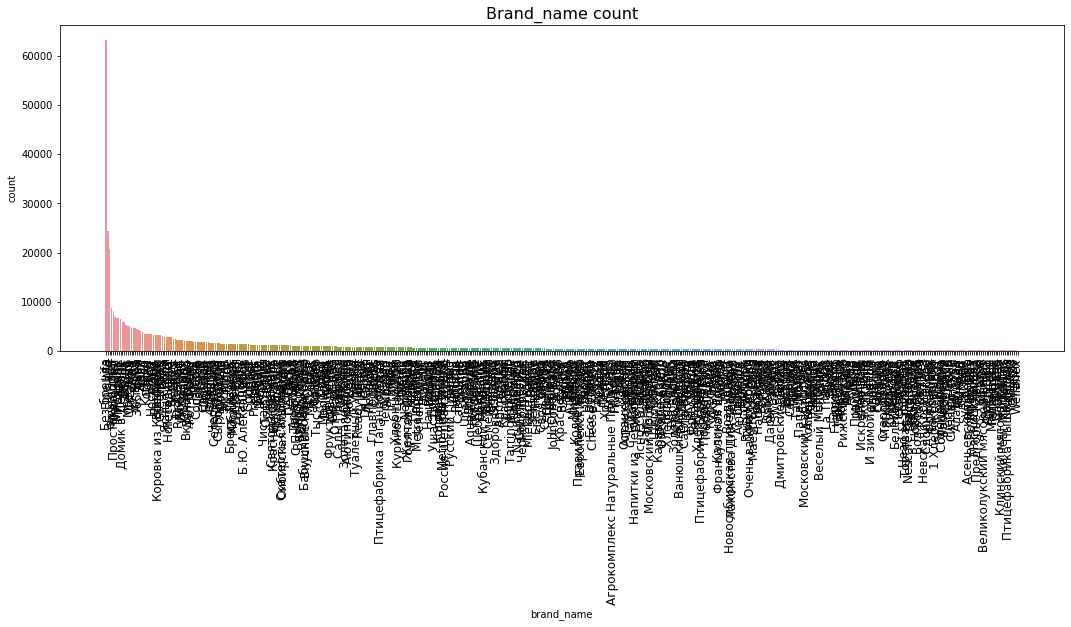

In [470]:
count_plot(prod_df, 'brand_name', top=500)